 **Garbage Classification Project**



## Setting Up Environment


1.   Import Libraries
2.   Verifying that GPU works
3.   Importing data from cluster/ add folder




Note: Data has already been already been split into train, validation, and test

In [1]:
import os
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import seaborn as sns
import pandas as pd
# PyTorch and Torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import ExponentialLR

# Transformers library for NLP model
from transformers import (
    XLMRobertaModel,
    XLMRobertaTokenizer,
    XLMRobertaForSequenceClassification,
    Trainer,
    TrainingArguments
)

# Learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Keras VGG19 for image model preprocessing
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image

# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

In [2]:
# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
# Text Preprocessing, and return garbage names array and labels array.
def preprocessing_garbage_name_with_labels(path):
    names=[]
    labels=[]
    dataset = datasets.ImageFolder(root = path).imgs
    for image in dataset:
        text = image[0].split('\\')[-1].split('.')[0]
        text = text.replace('_',' ').lower()
        text = re.sub(r'\d+', '', text).strip()
        names.append(text)
        labels.append(image[1])
        
    return np.array(names), np.array(labels)

In [4]:
#Image Path

train_dir = r"./garbage_data\CVPR_2024_dataset_Val"
val_dir = r"./garbage_data\CVPR_2024_dataset_Train"
test_dir  = r"./garbage_data\CVPR_2024_dataset_Test"


#Image Preprocessing
torchvision_transform = transforms.Compose([
    transforms.Resize((224, 224)),                    # Resize to 224x224
    transforms.ColorJitter(brightness=0.2,            # Randomly adjust brightness
                          contrast=0.2,              # Randomly adjust contrast
                          saturation=0.2,            # Randomly adjust saturation
                          hue=0.1),                  # Randomly adjust hue
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),  # Randomly adjust sharpness
    transforms.RandomHorizontalFlip(),                 # Data Augmentation
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),                             # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # Normalize based on ImageNet
                         std=[0.229, 0.224, 0.225]),
])

torchvision_transform_test = transforms.Compose([
    transforms.Resize((224, 224)),                    # Resize to 224x224
    transforms.ColorJitter(brightness=0.2,            # Randomly adjust brightness
                          contrast=0.2,              # Randomly adjust contrast
                          saturation=0.2,            # Randomly adjust saturation
                          hue=0.1),                  # Randomly adjust hue
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),  # Randomly adjust sharpness
    transforms.RandomHorizontalFlip(),                 # Data Augmentation
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),                             # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # Normalize based on ImageNet
                         std=[0.229, 0.224, 0.225]),
])

# Load datasets with ImageFolder using the custom transformations
train_image_dataset = ImageFolder(root=train_dir, transform=torchvision_transform)
val_image_dataset = ImageFolder(root=val_dir, transform=torchvision_transform)
test_image_dataset = ImageFolder(root=test_dir, transform=torchvision_transform)

# Create data loaders
batch_size = 32
train_image_loader = DataLoader(train_image_dataset, batch_size=batch_size, shuffle=True, num_workers= 2)
val_image_loader = DataLoader(val_image_dataset, batch_size=batch_size, shuffle=False, num_workers= 2)
test_image_loader = DataLoader(test_image_dataset, batch_size=batch_size, shuffle=False, num_workers= 2)



# Image Model


*   Preprocessing of images: contrast, sharpen, boost contrast, and highlight edges
*   Using VGG19 model to learn features of images


*   Set your callbacks and track your experiments
- Early stopping - patience
- Model check point
- Learning rate scheduler
- Weights and biases (train/val loss)
- Set your main hyperparameters
- batch size
- learning rate
- number of epochs

Test
Run prediction on the test set
- Accuracy





In [5]:
class_names = train_image_dataset.classes
print(class_names)
print("Train set:", len(train_image_loader)*batch_size)
print("Val set:", len(val_image_loader)*batch_size)
print("Test set:", len(test_image_loader)*batch_size)

#Customuze garbage model by using VGG19 for Garbage image classification
class GarbageModel(nn.Module):
    def __init__(self, num_classes, input_shape, transfer=False):
        super(GarbageModel, self).__init__()

        self.transfer = transfer
        self.num_classes = num_classes
        self.input_shape = input_shape

        # Load VGG19 with optional pretrained weights
        self.feature_extractor = models.vgg19(weights="IMAGENET1K_V1" if transfer else None)

        if self.transfer:
            # Freeze all layers if using transfer learning
            for param in self.feature_extractor.parameters():
                param.requires_grad = False

        # Determine the feature size after flattening
        n_features = self._get_conv_output(self.input_shape)
        
        # Add a classifier with dropout and ReLU for improved generalization
        self.classifier = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def _get_conv_output(self, shape):
        batch_size = 1
        tmp_input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self.feature_extractor(tmp_input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    def forward(self, x):
        # Extract features with VGG19
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Pass through the classifier
        x = self.classifier(x)
        return x


['Black', 'Blue', 'Green', 'TTR']
Train set: 1824
Val set: 10208
Test set: 3456


In [6]:
#Iterate training dataset and show preprocessed image
train_iterator = iter(train_image_loader)
train_batch = next(train_iterator)

In [7]:
print(train_batch[0].size())
print(train_batch[1].size())

torch.Size([32, 3, 224, 224])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


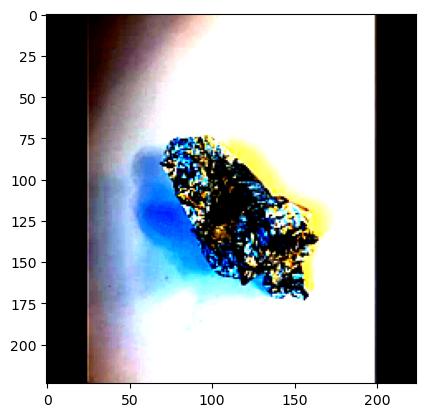

In [8]:
plt.figure()
plt.imshow(train_batch[0].numpy()[16].transpose(1,2,0))
plt.show()

In [9]:
# Show VGG19 model after initialized
net = GarbageModel(4, (3,224,224), True)
net.to(device)

GarbageModel(
  (feature_extractor): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=T

In [10]:
#Add loss function and optimizer for training
#ALso add scheduler for early stopping based on patience
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.AdamW(net.parameters(), lr = 0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
PATH = './save/best_image_model.pth'

In [11]:
%%skip 
num_epochs = 50  # Start with a higher number, but use early stopping
best_val_accuracy = 0 # Record the best accuracy to check if improved
epochs_no_improve = 0
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
min_delta = 0.01  # Minimum change to count as an improvement
early_stop = False
for epoch in range(num_epochs):
    # Training loop (same as before)
    train_loss = 0.0
    for i, data in enumerate(train_image_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f'Epoch {epoch+1}, train loss: {train_loss / (i+1):.3f},', end=' ')

    # Validation loop
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_image_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

        print(f'val loss: {val_loss / (i+1):.3f}')

    # Early stopping mechanism
    if val_loss < best_val_loss - min_delta:  # Check for significant improvement
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(net.state_dict(), PATH)
        print("Model Saved!")
    else:
        epochs_no_improve += 1

    # If no improvement after patience epochs, stop training
    if epochs_no_improve >= patience:
        print("Early stopping triggered!")
        early_stop = True
        break

    # Reduce learning rate if necessary (scheduler step)
    scheduler.step(val_loss)

if not early_stop:
    print("Finished training!")


UsageError: Cell magic `%%skip` not found.


In [ ]:
# Load the best model to be used in the test set
net = GarbageModel(4, (3,224,224), False)
net.load_state_dict(torch.load(PATH))
net.to(device)

In [ ]:
# Plot the incorrect classification garbage image
def plot_incorrect_classifications(dataloader, incorrect_indices, predictions, true_labels, num_samples=10):
    dataloader_iter = iter(dataloader)
    for idx, batch in enumerate(dataloader_iter):
        if idx in incorrect_indices[:num_samples]:  # Limit to first few incorrect samples
            image, label = batch
            pred_label = predictions[idx]
            true_label = true_labels[idx]
            print(f"Predicted Label: {pred_label}, True Label: {true_label}")
            # Display image with true and predicted labels
            plt.imshow(image[0].permute(1, 2, 0).cpu().numpy())  # Adjust if format is (C, H, W)
            plt.title(f"True: {class_names[true_label]}, Pred: {class_names[pred_label]}")
            plt.axis("off")
            plt.show()

In [ ]:
# Using trained model to predict output of test dataset, and calculate the accuracy
# Initialize lists to store predictions and true labels
def evaluate_and_plot_metrics(model, dataloader, class_names, device):
    """
    Evaluates the model on the test dataset, calculates and displays classification metrics,
    and plots a confusion matrix. Also identifies incorrect classifications.
    
    Args:
    - model (torch.nn.Module): The trained model.
    - dataloader (torch.utils.data.DataLoader): DataLoader for the test dataset.
    - class_names (list of str): List of class names for labeling.
    - device (torch.device): Device on which to run the model (CPU or GPU).
    
    Returns:
    - all_predictions (np.ndarray): Array of predicted labels for each sample.
    - all_labels (np.ndarray): Array of true labels for each sample.
    - incorrect_indices (np.ndarray): Indices of incorrectly classified samples.
    """
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        total, correct = 0, 0
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Store predictions and true labels
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate overall accuracy
    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

    # Convert lists to numpy arrays for further metric calculations
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Print classification report
    print("Classification Report:")
    report = classification_report(all_labels, all_predictions, target_names=class_names, output_dict=True)
    print(pd.DataFrame(report).transpose())

    # Confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Identify incorrect classifications
    incorrect_indices = np.where(all_predictions != all_labels)[0]
    print(f"Number of incorrect classifications: {len(incorrect_indices)}")

    return all_predictions, all_labels, incorrect_indices
    
all_predictions, all_labels, incorrect_indices = evaluate_and_plot_metrics(net, test_image_loader, class_names, device)
# Run function to display incorrect classifications
plot_incorrect_classifications(test_image_loader, incorrect_indices, all_predictions, all_labels)

# Text Model


- preprocessing of text: (find out what needs to be done) Tokenization, stopword removal, word embeddings (capitilization maybe)

- Use XLMRoBERTa to transfer learning model on text

- Next Steps: Fuse text model and image model

- Calculate accuracy for the mi

- confusion matrix

In [ ]:
# Customized garbage dataset for text model, and using XLMRoBETa to transfer learning.
class GarbageDataset(torch.utils.data.Dataset):
    def __init__(self, names, labels, tokenizer, max_len):
        self.names = names
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        image_name = self.names[idx]
        label = self.labels[idx]

        # Tokenize the text label
        encoding = self.tokenizer.encode_plus(
            image_name,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'image_name': image_name,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

class CustomXLMRobertaModel(nn.Module):
    def __init__(self, num_labels=4):
        super(CustomXLMRobertaModel, self).__init__()
        
        # Load pre-trained XLM-RoBERTa model
        self.xlm_roberta = XLMRobertaModel.from_pretrained("xlm-roberta-base")
        
        # Define a custom classifier layer
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),            # Dropout for regularization
            nn.Linear(self.xlm_roberta.config.hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_labels)  # Output layer for the number of labels
        )

    def forward(self, input_ids, attention_mask):
        # Pass inputs through the XLM-RoBERTa model
        outputs = self.xlm_roberta(input_ids=input_ids, attention_mask=attention_mask)
        
        # Extract the last hidden state of the [CLS] token
        cls_output = outputs.last_hidden_state[:, 0, :]
        
        # Pass the CLS output through the custom classifier
        logits = self.classifier(cls_output)
        
        return logits

# Customized training, evalutae, and predict method.
def train(model, iterator, optimizer, criterion, device):
    model.train()  # Set model to training mode
    total_loss = 0

    for batch in iterator:
        # Move batch data to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
   
        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters

        total_loss += loss.item()

    return total_loss / len(iterator)  # Average loss over the batches



def evaluate(model, iterator, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for batch in iterator:
            # Move batch data to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
   

            # Compute loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    return total_loss / len(iterator) 

def predict(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    predictions = []

    with torch.no_grad():  # Disable gradient tracking
        for batch in dataloader:
            # Move batch data to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Get predicted class with highest score
            _, preds = torch.max(outputs, dim=1)
          
            # Convert predictions to CPU and append to list
            predictions.extend(preds.cpu().numpy())

    return predictions

In [ ]:
# Add XLMRoBERTa based tokenizer for text.
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

In [ ]:
# Create dataset and dataloader for train, validation and test.
names_text_val, labels_text_val = preprocessing_garbage_name_with_labels(val_dir)
names_text_train, labels_text_train  = preprocessing_garbage_name_with_labels(train_dir)
names_text_test, labels_text_test = preprocessing_garbage_name_with_labels(test_dir)

max_len = 24
dataset_text_train = GarbageDataset(names_text_train, labels_text_train, tokenizer, max_len)
dataset_text_val = GarbageDataset(names_text_val, labels_text_val, tokenizer, max_len)
dataset_text_test = GarbageDataset(names_text_test, labels_text_test, tokenizer, max_len)

# Data loaders
train_text_loader = DataLoader(dataset_text_train, batch_size=batch_size, shuffle=True)
val_text_loader = DataLoader(dataset_text_val, batch_size=batch_size, shuffle=False)
test_text_loader = DataLoader(dataset_text_test, batch_size=batch_size, shuffle=False)

print(names_text_val, labels_text_val)

In [ ]:
# Instantiate  model
model = CustomXLMRobertaModel().to(device)

# Initialize loss function an optimizer
optimizer = optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Initialize ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)



In [ ]:
%%skip 
# Setting max training epoch and patience
EPOCHS = 20
patience = 3  # Stop after 3 epochs without improvement
best_loss = float('inf')
no_improve_epochs = 0

print("Training Start...")
for epoch in range(EPOCHS):
    # Training
    train_loss = train(model, train_text_loader, optimizer, criterion, device)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}')
    
    # Validation
    val_loss = evaluate(model, val_text_loader, criterion, device)
    print(f'Epoch: {epoch+1}, Val Loss: {val_loss:.4f}')
    
    # Check for improvement
    if val_loss < best_loss:
        best_loss = val_loss
        no_improve_epochs = 0  # Reset patience counter
        torch.save(model.state_dict(), './save/best_text_model.pth')
        print("Model improved; saved.")
    else:
        no_improve_epochs += 1
        print(f"No improvement for {no_improve_epochs} epoch(s).")
    
    # Early stopping
    if no_improve_epochs >= patience:
        print("Early stopping triggered. No improvement in validation loss.")
        break

In [ ]:
# Load best text model
model.load_state_dict(torch.load('best_text_model.pth'))
model.to(device)

In [ ]:

def evaluate_predictions(predictions, true_labels, class_names, num_samples=10):
    """
    Evaluates the model predictions against true labels, calculates metrics,
    and plots a confusion matrix. Displays examples of incorrect classifications.
    
    Args:
    - predictions (array-like): Array of predicted labels.
    - true_labels (array-like): Array of true labels.
    - class_names (list of str): List of class names for labeling.
    - num_samples (int): Number of incorrect classifications to display.
    """
    # Convert predictions and true labels to numpy arrays if they aren't already
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Accuracy: {accuracy:.4f}")

    # Classification report
    print("Classification Report:")
    report = classification_report(true_labels, predictions, target_names=class_names, output_dict=True)
    print(pd.DataFrame(report).transpose())

    # Confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
    

def plot_incorrect_classifications_text(dataloader, predictions, true_labels, class_names, num_samples=10):
    """
    Displays names of incorrectly classified items along with true and predicted labels.
    
    Args:
    - dataloader (DataLoader): DataLoader for the test dataset.
    - predictions (array-like): Array of predicted labels.
    - true_labels (array-like): Array of true labels.
    - class_names (list of str): List of class names for labeling.
    - num_samples (int): Number of incorrect samples to display.
    """
    # Identify incorrect classifications
    incorrect_indices = np.where(predictions != true_labels)[0]
    incorrect_indices = incorrect_indices[:num_samples]  # Limit to the first few incorrect samples
    
    displayed = 0  # Count displayed incorrect samples

    print("Incorrect Classifications:")
    
    # Create an iterator over the dataloader
    for batch in dataloader:
        if displayed >= num_samples:
            break

        # Extract fields from the batch
        image_names = batch['image_name']  # List of item names
        labels = batch['labels'].cpu().numpy()
        
        # Get the predictions for the current batch
        batch_size = labels.shape[0]
        batch_predictions = predictions[displayed: displayed + batch_size]
        
        # Find incorrect classifications within this batch
        batch_incorrect_indices = np.where(batch_predictions != labels)[0]
        
        for idx in batch_incorrect_indices:
            if displayed >= num_samples:
                break
            
            # Retrieve item name, true label, and predicted label
            item_name = image_names[idx]
            true_label = labels[idx]
            pred_label = batch_predictions[idx]

            # Print the item name, true label, and predicted label
            print(f"Item: {item_name}\nPredicted Label: {class_names[pred_label]}, True Label: {class_names[true_label]}\n")
            
            displayed += 1
# Show the matrix and incorrect classification

predictions = predict(model, test_text_loader, device)
evaluate_predictions(predictions, labels_text_test, class_names)
plot_incorrect_classifications_text(test_text_loader, predictions, labels_text_test, class_names)

# Fusion

*Evaluating Model Performance


*   Accuracy
*  Precision


*   Confusion Matrix





In [ ]:
# Fusing image and text model based on weight
class FusionModel(nn.Module):
    def __init__(self, image_model, text_model, num_classes, image_weight=0.5, text_weight=0.5):
        super(FusionModel, self).__init__()
        
        # Initialize the pretrained models
        self.image_model = image_model
        self.text_model = text_model

        # Set initial weights as learnable parameters
        self.image_gate = nn.Parameter(torch.tensor(image_weight, dtype=torch.float32))
        self.text_gate = nn.Parameter(torch.tensor(text_weight, dtype=torch.float32))
        
        # Determine output dimension of the image model
        dummy_image_input = torch.randn(1, 3, 224, 224)
        image_features = self.image_model(dummy_image_input)
        image_output_dim = image_features.view(1, -1).size(1)

        # Determine output dimension of the text model
        dummy_text_input_ids = torch.randint(0, 1000, (1, 24))
        dummy_text_attention_mask = torch.ones((1, 24))
        text_features = self.text_model(dummy_text_input_ids, dummy_text_attention_mask)
        text_output_dim = text_features.size(1)
        
        # Define transformation layers for image and text features
        self.image_transform = nn.Linear(image_output_dim, image_output_dim)
        self.text_transform = nn.Linear(text_output_dim, text_output_dim)

        # Fusion layer and classifier with increased dimensions
        self.fusion_layer = nn.Linear(image_output_dim + text_output_dim, 256)
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, image_input, text_input_ids, text_attention_mask):
        # Pass through image model
        image_features = self.image_model(image_input)
        image_features = image_features.view(image_features.size(0), -1)
        image_features = F.relu(self.image_transform(image_features))

        # Pass through text model
        text_features = self.text_model(input_ids=text_input_ids, attention_mask=text_attention_mask)
        text_features = F.relu(self.text_transform(text_features))

        # Apply gated weighting (learnable weights)
        weighted_image_features = image_features * self.image_gate
        weighted_text_features = text_features * self.text_gate

        # Concatenate weighted features and pass through fusion layer and classifier
        combined_features = torch.cat((weighted_image_features, weighted_text_features), dim=1)
        fusion_output = self.fusion_layer(combined_features)
        output = self.classifier(fusion_output)
        
        return output



In [ ]:
# Dataset using for training fused model, data set will include image and text dataset.
class CombinedDataset(Dataset):
    def __init__(self, image_dataset, text_dataset):
        self.image_dataset = image_dataset
        self.text_dataset = text_dataset
        assert len(self.image_dataset) == len(self.text_dataset), "Image and text datasets must be of equal length"

    def __len__(self):
        return len(self.image_dataset)

    def __getitem__(self, idx):
        # Get image and label from image dataset
        image, label_image = self.image_dataset[idx]
        
        # Get text data (dictionary) from text dataset
        text_data = self.text_dataset[idx]
        text_input_ids = text_data['input_ids']
        text_attention_mask = text_data['attention_mask']
        label_text = text_data['labels']
        
        # Ensure the labels match
        assert label_image == label_text, "Labels from image and text datasets must match"

        return image, text_input_ids, text_attention_mask, label_image

In [ ]:
# Define dataset and dataloader for combined dataset
combined_train_dataset = CombinedDataset(train_image_dataset, dataset_text_train)
combined_train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True)
combined_val_dataset = CombinedDataset(val_image_dataset, dataset_text_val)
combined_val_loader = DataLoader(combined_val_dataset, batch_size=batch_size, shuffle=False)
combined_test_dataset = CombinedDataset(test_image_dataset, dataset_text_test)
combined_test_loader = DataLoader(combined_test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def train_fusion_model(
    fusion_model,
    combined_train_loader,
    combined_val_loader,
    device,
    num_epochs=50,
    lr=1e-4,
    early_stop_patience=5,
    save_path='./save/best_fusion_model.pth'
):
    # Unfreeze the last 10 layers for the image and text model
    for param in list(fusion_model.image_model.parameters())[-10:]:
        param.requires_grad = True
    for param in list(fusion_model.text_model.parameters())[-10:]:
        param.requires_grad = True

    # Define optimizer and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(fusion_model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    print("Training Started")
    for epoch in range(num_epochs):
        # Training phase
        fusion_model.train()
        running_loss = 0.0
        for image, text_input_ids, text_attention_mask, labels in combined_train_loader:
            image, text_input_ids, text_attention_mask, labels = (
                image.to(device),
                text_input_ids.to(device),
                text_attention_mask.to(device),
                labels.to(device)
            )

            # Forward pass
            outputs = fusion_model(image, text_input_ids, text_attention_mask)
            loss = criterion(outputs, labels)

            # Backward and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation phase
        fusion_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for image, text_input_ids, text_attention_mask, labels in combined_val_loader:
                image, text_input_ids, text_attention_mask, labels = (
                    image.to(device),
                    text_input_ids.to(device),
                    text_attention_mask.to(device),
                    labels.to(device)
                )

                outputs = fusion_model(image, text_input_ids, text_attention_mask)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(combined_val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss / len(combined_train_loader):.4f}, Validation Loss: {val_loss:.4f}")

        # Step scheduler based on validation loss
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            # Save the best model
            torch.save(fusion_model.state_dict(), save_path)
            print("Model Saved!")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= early_stop_patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    print("Training complete.")

In [ ]:
# Cusomized predict method for fused model
def combine_predict(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    predictions = []

    with torch.no_grad():  # Disable gradient tracking
        for batch in dataloader:
            # Move batch data to device
            image_input = batch[0].to(device)             # Assuming the first element is image data
            input_ids = batch[1].to(device)               # Assuming the second element is input_ids for text
            attention_mask = batch[2].to(device)          # Assuming the third element is attention_mask for text
            
            # Forward pass
            outputs = model(image_input, input_ids, attention_mask)

            # Get predicted class with highest score
            _, preds = torch.max(outputs, dim=1)
          
            # Convert predictions to CPU and append to list
            predictions.extend(preds.cpu().numpy())

    return predictions

In [ ]:
def plot_incorrect_classifications(dataloader, predictions, true_labels, class_names, image_names, num_samples=10):
    """
    Plots images of incorrectly classified items with their true and predicted labels and image names.
    
    Args:
    - dataloader (DataLoader): DataLoader for the combined dataset.
    - predictions (array-like): Array of predicted labels.
    - true_labels (array-like): Array of true labels.
    - class_names (list of str): List of class names for labeling.
    - image_names (list of str): List of image names corresponding to the true labels.
    - num_samples (int): Number of incorrect samples to display.
    """
    # Identify incorrect classifications
    incorrect_indices = np.where(predictions != true_labels)[0]
    incorrect_indices = incorrect_indices[:num_samples]  # Limit to the first few incorrect samples
    
    displayed = 0  # Track number of displayed images
    
    print("Incorrect Classifications:")
    
    # Iterator over the dataloader to fetch images
    dataloader_iter = iter(dataloader)
    
    for batch_num, batch in enumerate(dataloader_iter):
        if displayed >= num_samples:
            break

        # Unpack the batch (without modification to CombinedDataset)
        images, text_input_ids, text_attention_mask, labels = batch

        # Move data to CPU for easier handling
        labels = labels.cpu().numpy()
        batch_predictions = predictions[batch_num * len(labels): (batch_num + 1) * len(labels)]
        
        # Find incorrect samples within this batch
        batch_incorrect_indices = np.where(batch_predictions != labels)[0]
        
        for idx in batch_incorrect_indices:
            if displayed >= num_samples:
                break
            
            # Retrieve image, true label, predicted label, and the corresponding image name from image_names
            image = images[idx]
            true_label = labels[idx]
            pred_label = batch_predictions[idx]
            image_name = image_names[batch_num * len(labels) + idx]  # Use the index from `image_names`
            
            # Display the image with true and predicted labels
            plt.imshow(image.permute(1, 2, 0).cpu().numpy())  # Adjust if image format is (C, H, W)
            plt.title(f"File: {image_name}\nTrue: {class_names[true_label]}, Pred: {class_names[pred_label]}")
            plt.axis("off")
            plt.show()
            
            displayed += 1

In [ ]:
%%skip 
# Calculated the fused model accuracy
# Initialize model with dimensions and weight contributions
# Load models
image_model = GarbageModel(4, (3,224,224), False)
image_model.load_state_dict(torch.load('./save/best_image_model.pth'))

text_model = CustomXLMRobertaModel()
text_model.load_state_dict(torch.load('./save/best_text_model.pth'))

num_epochs = 50
learning_rate = 1e-4
early_stop_patience = 5
save_path = './save/best_fusion_model_0.5_0.5.pth'
# Freeze models if needed
for param in image_model.parameters():
    param.requires_grad = False
for param in text_model.parameters():
    param.requires_grad = False

fusion_even_model = FusionModel(
    image_model=image_model, 
    text_model=text_model, 
    num_classes=4, 
    image_weight=0.5,   # Specify initial weight for image features
    text_weight=0.5     # Specify initial weight for text features
)
fusion_even_model.to(device)



In [ ]:
%%skip 
train_fusion_model(
    fusion_model=fusion_even_model,
    combined_train_loader=combined_train_loader,
    combined_val_loader=combined_val_loader,
    device=device,
    num_epochs=num_epochs,
    lr=learning_rate,
    early_stop_patience=early_stop_patience,
    save_path=save_path
)

In [ ]:
%%skip 
# evaluate_predictions(test_predictions, labels_text_test, class_names
fusion_even_model.load_state_dict(torch.load(save_path))
fusion_even_model.to(device)
test_predictions = combine_predict(fusion_even_model, combined_test_loader, device)
evaluate_predictions(predictions, labels_text_test, class_names)
plot_incorrect_classifications(combined_test_loader, test_predictions, labels_text_test, class_names, names_text_test)

In [ ]:
# Calculated the fused model accuracy
# Initialize model with dimensions and weight contributions
image_model = GarbageModel(4, (3,224,224), False)
image_model.load_state_dict(torch.load('./save/best_image_model.pth'))

text_model = CustomXLMRobertaModel()
text_model.load_state_dict(torch.load('./save/best_text_model.pth'))

num_epochs = 50
learning_rate = 1e-4
early_stop_patience = 5
save_path = './save/best_fusion_model_0.25_0.75.pth'
# Freeze models if needed
for param in image_model.parameters():
    param.requires_grad = False
for param in text_model.parameters():
    param.requires_grad = False

fusion_text_model = FusionModel(
    image_model=image_model, 
    text_model=text_model, 
    num_classes=4, 
    image_weight=0.25,   # Specify initial weight for image features
    text_weight=0.75     # Specify initial weight for text features
)
fusion_text_model.to(device)
train_fusion_model(
    fusion_model=fusion_text_model,
    combined_train_loader=combined_train_loader,
    combined_val_loader=combined_val_loader,
    device=device,
    num_epochs=num_epochs,
    lr=learning_rate,
    early_stop_patience=early_stop_patience,
    save_path=save_path
)

In [ ]:
# evaluate_predictions(test_predictions, labels_text_test, class_names)
fusion_text_model.load_state_dict(torch.load(save_path))
fusion_text_model.to(device)
test_predictions = combine_predict(fusion_text_model, combined_test_loader, device)
evaluate_predictions(predictions, labels_text_test, class_names)
plot_incorrect_classifications(combined_test_loader, test_predictions, labels_text_test, class_names, names_text_test)

In [ ]:
%%skip 
# Calculated the fused model accuracy
# Initialize model with dimensions and weight contributions
image_model = GarbageModel(4, (3,224,224), False)
image_model.load_state_dict(torch.load('./save/best_image_model.pth'))

text_model = CustomXLMRobertaModel()
text_model.load_state_dict(torch.load('./save/best_text_model.pth'))

num_epochs = 50
learning_rate = 1e-4
early_stop_patience = 5
save_path = './save/best_fusion_model_0.75_0.25.pth'
# Freeze models if needed
for param in image_model.parameters():
    param.requires_grad = False
for param in text_model.parameters():
    param.requires_grad = False

fusion_image_model = FusionModel(
    image_model=image_model, 
    text_model=text_model, 
    num_classes=4, 
    image_weight=0.75,   # Specify initial weight for image features
    text_weight=0.25     # Specify initial weight for text features
)

train_fusion_model(
    fusion_model=fusion_image_model,
    combined_train_loader=combined_train_loader,
    combined_val_loader=combined_val_loader,
    device=device,
    num_epochs=num_epochs,
    lr=learning_rate,
    early_stop_patience=early_stop_patience,
    save_path=save_path
)

In [ ]:
%%skip 
# evaluate_predictions(test_predictions, labels_text_test, class_names)
fusion_image_model.load_state_dict(torch.load(save_path))
fusion_image_model.to(device)
test_predictions = combine_predict(fusion_image_model, combined_test_loader, device)
evaluate_predictions(predictions, labels_text_test, class_names)
plot_incorrect_classifications(combined_test_loader, test_predictions, labels_text_test, class_names, names_text_test)

In [ ]:
# Alarm indicated training complete
import winsound
winsound.Beep(440,1000)